In [ ]:
!python -m pip install pykalman

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 248.5/248.5 kB 5.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 145.5/145.5 kB 10.8 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_absolute_error
from statsmodels.graphics.tsaplots import plot_acf
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from pykalman import KalmanFilter
from sklearn.impute import KNNImputer
import time as time
import itertools
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
import itertools


In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
def zero_imputation(univariate_data_train,univariate_data_test):
    train_univariate_data_imputed = np.nan_to_num(univariate_data_train, nan=0)
    test_univariate_data_imputed=np.nan_to_num(univariate_data_test, nan=0)
    return train_univariate_data_imputed,test_univariate_data_imputed

def mean_imputation(univariate_data_train,univariate_data_test):
    mean_value = np.nanmean(univariate_data_train)  # NaN değerleri hariç ortalama hesapla
    train_univariate_data_imputed = np.where(np.isnan(univariate_data_train), mean_value, univariate_data_train)
    test_univariate_data_imputed= np.where(np.isnan(univariate_data_test), mean_value, univariate_data_test)
    return train_univariate_data_imputed,test_univariate_data_imputed

def random_imputation(univariate_data_train,univariate_data_test):
    valid_values = univariate_data_train[~np.isnan(univariate_data_train)]  # NaN olmayan değerleri seç
    if len(valid_values) == 0:
        return univariate_data_train  # Eğer tüm değerler NaN ise değiştirme
    random_values = np.random.choice(valid_values, size=np.isnan(univariate_data_train).sum())  # Rastgele değerler seç
    train_univariate_data_imputed = np.copy(univariate_data_train)
    train_univariate_data_imputed[np.isnan(univariate_data_train)] = random_values

    test_univariate_data_imputed=np.copy(univariate_data_test)
    valid_values_test = univariate_data_test[~np.isnan(univariate_data_test)]  # NaN olmayan değerleri seç
    mask_test = np.isnan(test_univariate_data_imputed)
    if len(valid_values_test) == 0:
        return univariate_data_test  # Eğer tüm değerler NaN ise değiştirme
    random_values_test = np.random.choice(valid_values, size=np.isnan(univariate_data_test).sum())  # trainden Rastgele değerler seç

    test_univariate_data_imputed[mask_test] = np.random.choice(valid_values, size=mask_test.sum(), replace=True)

    return train_univariate_data_imputed,test_univariate_data_imputed

def median_imputation(univariate_data_train,univariate_data_test):
    """
    NumPy array içindeki NaN (eksik) değerleri medyan (median) ile doldurur.
    """
    median_value = np.nanmedian(univariate_data_train)  # NaN değerleri hariç medyan hesapla
    train_univariate_data_imputed = np.where(np.isnan(univariate_data_train), median_value, univariate_data_train)
     # NaN olanları medyan ile değiştir
    test_univariate_data_imputed= np.where(np.isnan(univariate_data_test), median_value, univariate_data_test) #trainin mediani ile doldur
    return train_univariate_data_imputed,test_univariate_data_imputed

def forward_fill_imputation(univariate_data_train,univariate_data_test):
    """
    NumPy array içindeki NaN (eksik) değerleri kendinden önce gelen ilk bilinen değerle doldurur.
    Eğer ilk değerler de NaN ise, dizideki ilk bilinen değeri alıp doldurur.
    """
    train_univariate_data_imputed = np.copy(univariate_data_train)
    mask = np.isnan(train_univariate_data_imputed)

    # Ardışık NaN'leri forward fill ile doldur
    for i in range(1, len(train_univariate_data_imputed)):
        if mask[i]:
            train_univariate_data_imputed[i] = train_univariate_data_imputed[i - 1]  # Önceki bilinen değeri ata

    # Eğer hala NaN kalan değerler varsa, bunları ilk bilinen değer ile doldur
    first_valid_idx = np.where(~mask)[0][0] if np.any(~mask) else None
    if first_valid_idx is not None:
        train_univariate_data_imputed[np.isnan(train_univariate_data_imputed)] = train_univariate_data_imputed[first_valid_idx]

    test_univariate_data_imputed = np.copy(univariate_data_test)
    mask = np.isnan(test_univariate_data_imputed)

    # Ardışık NaN'leri forward fill ile doldur
    for i in range(1, len(test_univariate_data_imputed)):
        if mask[i]:
            test_univariate_data_imputed[i] = test_univariate_data_imputed[i - 1]  # Önceki bilinen değeri ata

    # Eğer hala NaN kalan değerler varsa, bunları ilk bilinen değer ile doldur
    first_valid_idx = np.where(~mask)[0][0] if np.any(~mask) else None
    if first_valid_idx is not None:
        test_univariate_data_imputed[np.isnan(test_univariate_data_imputed)] = train_univariate_data_imputed[-1] #trainin son değeri ile doldur

    return train_univariate_data_imputed,test_univariate_data_imputed

def backward_fill_imputation(univariate_data_train,univariate_data_test):
    """
    NumPy array içindeki NaN (eksik) değerleri kendinden sonraki ilk bilinen değerle doldurur.
    Eğer son değerler de NaN ise, dizideki son bilinen değeri alıp doldurur.
    """
    train_univariate_data_imputed = np.copy(univariate_data_train)
    mask = np.isnan(train_univariate_data_imputed)


    # Ardışık NaN'leri backward fill ile doldur
    for i in range(len(train_univariate_data_imputed) - 2, -1, -1):
        if mask[i]:
            train_univariate_data_imputed[i] = train_univariate_data_imputed[i + 1]  # Sonraki bilinen değeri ata

    # Son bilinen değeri bul
    last_valid_idx = np.where(~mask)[0][-1] if np.any(~mask) else None

    # Eğer son değerler NaN ise, son bilinen değeri ile doldur
    if last_valid_idx is not None:
        train_univariate_data_imputed[last_valid_idx + 1:] = train_univariate_data_imputed[last_valid_idx]

    test_univariate_data_imputed = np.copy(univariate_data_test)
    mask = np.isnan(univariate_data_test)


    # Ardışık NaN'leri backward fill ile doldur
    for i in range(len(test_univariate_data_imputed) - 2, -1, -1):
        if mask[i]:
            test_univariate_data_imputed[i] = test_univariate_data_imputed[i + 1]  # Sonraki bilinen değeri ata

    # Son bilinen değeri bul
    last_valid_idx = np.where(~mask)[0][-1] if np.any(~mask) else None

    # Eğer son değerler NaN ise, son bilinen değeri ile doldur
    if last_valid_idx is not None:
        test_univariate_data_imputed[last_valid_idx + 1:] = train_univariate_data_imputed[-1]  #trainin son değeri ile doldur

    return train_univariate_data_imputed,test_univariate_data_imputed

def interpolation_imputation(univariate_data_train,univariate_data_test):
    """
    NumPy array içindeki NaN (eksik) değerleri doğrusal interpolasyon ile doldurur.
    """
    series_data = pd.Series(univariate_data_train)
    train_univariate_data_imputed = series_data.interpolate(method='linear', limit_direction='both').to_numpy()

    combined_data = np.concatenate([train_univariate_data_imputed, univariate_data_test])  # Train + Test birleştirildi

    # Birleştirilmiş seriyi oluştur ve interpolasyon uygula
    combined_series = pd.Series(combined_data)
    combined_imputed = combined_series.interpolate(method='linear', limit_direction='both').to_numpy()

    # Sadece Test Setini Çıkar
    test_univariate_data_imputed = combined_imputed[len(univariate_data_train):]  # Test kısmını çek

    return train_univariate_data_imputed, test_univariate_data_imputed

def kalman_filter_imputation(univariate_data_train, univariate_data_test):
    """
    NumPy array içindeki NaN (eksik) değerleri Kalman Filtresi ile doldurur.
    Ancak sadece eksik olan yerleri doldurur, diğer verilere dokunmaz.
    """
    # Kalman filtresi başlat
    kf = KalmanFilter(
        initial_state_mean=0,
        n_dim_obs=1,
        initial_state_covariance=1,
        transition_matrices=[1],
        observation_matrices=[1],
        transition_covariance=1,
        observation_covariance=1
    )

    # 1. Aşama: train verisi için Kalman smooth uygulayalım
    mask_train = np.isnan(univariate_data_train)
    observations_train = np.ma.array(univariate_data_train, mask=mask_train)
    train_smoothed, _ = kf.smooth(observations_train)

    # Sadece NaN olan yerlere smoothed değerleri yerleştir
    train_imputed = univariate_data_train.copy()
    train_imputed[mask_train] = train_smoothed[mask_train].flatten()

    # 2. Aşama: Train (doldurulmuş) + Test birleştir, test kısmını doldur
    combined_data = np.concatenate([train_imputed, univariate_data_test])
    mask_combined = np.isnan(combined_data)
    observations_combined = np.ma.array(combined_data, mask=mask_combined)

    # Kalman filtresiyle smooth işlemi
    combined_smoothed, _ = kf.smooth(observations_combined)

    # Test kısmını ayır
    test_imputed = combined_smoothed[len(train_imputed):]

    return train_imputed.flatten(), test_imputed.flatten()
from sklearn.svm import SVR
def svr_imputation_separate(train, test, n_lags=3):
    def create_lagged_df(series):
        df = pd.DataFrame({'y': series})
        for i in range(1, n_lags + 1):
            df[f'lag_{i}'] = df['y'].shift(i)
        return df

    feature_names = [f'lag_{i}' for i in range(1, n_lags + 1)]
    train_df = create_lagged_df(pd.Series(train)).dropna()
    X_train = train_df[feature_names].to_numpy()
    y_train = train_df['y'].to_numpy()
    svr = SVR().fit(X_train, y_train)

    train_filled = np.copy(train)
    for idx in np.where(np.isnan(train))[0]:
        if idx >= n_lags and not np.isnan(train[idx - n_lags:idx]).any():
            x_pred = train[idx - n_lags:idx][::-1].reshape(1, -1)
            train_filled[idx] = svr.predict(x_pred)[0]
    train_filled = pd.Series(train_filled).interpolate().bfill().ffill().to_numpy()

    test_filled = np.copy(test)
    for idx in np.where(np.isnan(test))[0]:
        full_input = np.concatenate([train_filled[-n_lags:], test[:idx]])
        if len(full_input) >= n_lags and not np.isnan(full_input[-n_lags:]).any():
            x_pred = full_input[-n_lags:][::-1].reshape(1, -1)
            test_filled[idx] = svr.predict(x_pred)[0]
    test_filled = pd.Series(test_filled).interpolate().bfill().ffill().to_numpy()
    return train_filled, test_filled


In [ ]:
import itertools
import time
import numpy as np
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error

def find_best_arima(train_data, validation_size=0.2, p_range=(0, 3), d_range=(0, 2), q_range=(0, 3), metric="rmse"):
    """
    Train verisi için en iyi (p, d, q) ARIMA parametrelerini seçer.

    - Eğer metric="rmse" ise, validation için train_data'yı ikiye böler ve bölünen train set ile modeli eğitir, doğrulama seti üzerinde RMSE hesaplar.
    - Eğer metric="aic" ise, tüm train_data ile modeli eğitir ve AIC'yi hesaplar.
    """

    best_score = float("inf")  # En iyi RMSE veya AIC değerini saklar
    best_params = None
    best_model = None

    # RMSE için train seti ayırma (validation kullanılır)
    if metric == "rmse":
        split_index = int(len(train_data) * (1 - validation_size))
        train_set, val_set = train_data[:split_index], train_data[split_index:]
    elif metric=="aic":
        train_set = train_data  # AIC için tüm veri kullanılır
        val_set = None  # AIC için validation set yok

    # Grid Search için tüm (p, d, q) kombinasyonlarını oluştur
    pdq_combinations = list(itertools.product(range(*p_range), range(*d_range), range(*q_range)))

    for pdq in pdq_combinations:
        try:
            if metric == "rmse":
                model = ARIMA(train_set, order=pdq)  # RMSE için sadece train_set ile eğit
            else:
                model = ARIMA(train_data, order=pdq)  # AIC için tüm train_data kullanılır

            model_fit = model.fit()

            # RMSE ile değerlendirme
            if metric == "rmse":
                predictions = model_fit.forecast(steps=len(val_set))
                rmse = np.sqrt(mean_squared_error(val_set, predictions))
                score = rmse
                print(f"ARIMA{pdq} - RMSE: {rmse}")

            # AIC ile değerlendirme
            elif metric == "aic":
                aic = model_fit.aic
                score = aic
                print(f"ARIMA{pdq} - AIC: {aic}")

            else:
                raise ValueError("metric parametresi 'rmse' veya 'aic' olmalıdır.")

            # En iyi modeli güncelle
            if score < best_score:
                best_score, best_params = score, pdq
                best_model = model_fit

        except Exception as e:
            print(f"ARIMA{pdq} başarısız: {e}")
            continue

    return best_params


In [ ]:
def modified_smape(y_true, y_pred):
    """
    Modified Symmetric Mean Absolute Percentage Error (sMAPE) hesaplama fonksiyonu.

    Parameters:
    y_true (array-like): Gerçek değerler.
    y_pred (array-like): Tahmin edilen değerler.

    Returns:
    float: Modified sMAPE değeri.
    """
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)

    # Denominator'i hesapla ve sıfır değerleri kaldır
    denominator = np.abs(y_true) + np.abs(y_pred)
    non_zero_indices = denominator != 0

    y_true_non_zero = y_true[non_zero_indices]
    y_pred_non_zero = y_pred[non_zero_indices]
    denominator_non_zero = denominator[non_zero_indices]

    # Modified sMAPE hesaplama
    smape_values = 2 * np.abs(y_true_non_zero - y_pred_non_zero) / denominator_non_zero

    return np.mean(smape_values) * 100

In [ ]:
import itertools
import numpy as np
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error

def rolling_window_arima_grid_search(data, p_range=(0, 3), d_range=(0, 2), q_range=(0, 3),
                                     train_size=0.8, window_size=1000):
    """
    Rolling Window Cross-Validation ile en iyi RMSE değerine sahip ARIMA (p, d, q) parametrelerini bulur.

    - train_size: Eğitim setinin oranı (örn: 0.8, yani %80 eğitim, %20 test)
    - window_size: Rolling Window eğitim penceresi boyutu
    - p_range, d_range, q_range: ARIMA için p, d, q değer aralıkları
    """

    best_params = None
    best_rmse = float("inf")
    window_size = max(500, min(int(len(data) * 0.1), 5000))


    # Eğitim ve test seti oluştur
    split_index = int(len(data) * train_size)
    train_data, test_data = data[:split_index], data[split_index:]

    # Grid Search için tüm (p, d, q) kombinasyonlarını oluştur
    pdq_combinations = list(itertools.product(range(*p_range), range(*d_range), range(*q_range)))

    # Grid Search (Tüm p, d, q kombinasyonlarını dene)
    for pdq in pdq_combinations:
        try:
            predictions = []
            actuals = []

            # Rolling Window ile çapraz doğrulama
            for i in range(len(test_data)):
                # Eğitim penceresini güncelle (Rolling Window)
                train_subset = train_data[max(0, len(train_data) - window_size + i) : len(train_data) + i]

                # ARIMA Modelini Eğit
                model = ARIMA(train_subset, order=pdq)
                model_fit = model.fit()

                # Bir adımlık tahmin yap
                pred = model_fit.forecast(steps=1)[0]

                predictions.append(pred)
                actuals.append(test_data[i])

            # RMSE Hesapla
            rmse = np.sqrt(mean_squared_error(actuals, predictions))
            print(f"ARIMA{pdq} - Rolling RMSE: {rmse}")

            # En iyi modeli güncelle
            if rmse < best_rmse:
                best_rmse = rmse
                best_params = pdq

        except Exception as e:
            print(f"ARIMA{pdq} başarısız: {e}")
            continue

    print(f"\nEn iyi parametreler: {best_params}, RMSE: {best_rmse}")
    return best_params


In [ ]:
#all data
results=[]
results.append(["Dataset","Imputation method","Imputation Time (train+test)","train time","Train MSE","Train MAE","Train RMSE","Train MS_MAPE","test time","Test MSE","Test MAE","Test RMSE","Test MS_MAPE","best paramater ARIMA"])


dataset_names_eskisehir=["Tepebasi_missing_with_existing_25pct.xlsx"]




imputation_methods = [
        zero_imputation,
        mean_imputation,
        median_imputation,
        forward_fill_imputation,
        backward_fill_imputation,
        interpolation_imputation,
        svr_imputation_separate,
        kalman_filter_imputation]


for name in dataset_names_eskisehir:
  #dataset_df=pd.read_csv("/content/drive/MyDrive/akademik çalışmalar/In progress/missing data in time series/VNS_dataset/"+name)
  #dataset_df=pd.read_excel("/content/drive/MyDrive/VNS_dataset/"+name)
  dataset_df = pd.read_excel("/content/drive/MyDrive/eksik_veri_simulasyonlari/Visnepark_missing_with_existing_10pct.xlsx")
  dataset_df.replace("-",np.nan,inplace=True)
  #dataset1 =  dataset_df.iloc[35049:]
  data = dataset_df.iloc[:,1].astype(float).to_numpy()
  #data=dataset
  # NaN olmayan değerleri filtrele
  #data = dataset[~np.isnan(dataset)]
  # ACF grafiğini çiz
  #plot_acf(data, lags=100)  # İlk 100 gecikmeyi göster
  #plt.show()
  print(len(data))

  # %80 ve %20 oranlarını belirle
  split_index = int(len(data) * 0.8)

  # Eğitim (Train) ve Test bölümleri
  train_data = data[:split_index]  # İlk %80
  test_data = data[split_index:]   # Son %20
  orig_mask = ~np.isnan(test_data)
  orig_mask_train = ~np.isnan(train_data)
  for method  in imputation_methods:
    start_imputation_time=time.time()
    print(method)
    imputed_train_full, imputed_test_full = method(np.copy(train_data),np.copy(test_data))
    stop_imputation_time=time.time()

    if np.isnan(imputed_train_full).sum()>0 or np.isnan(imputed_test_full).sum()>0:
      print("there are missing values in data")
      break
    print(np.isnan(train_data).sum())
    test_data_copy = np.copy(test_data)
    test_nan_mask = np.isnan(test_data_copy)
    final_test_imputed = np.copy(test_data_copy)
    final_test_imputed[test_nan_mask] = imputed_test_full[test_nan_mask]
    imputed_test = final_test_imputed  # Bundan sonra imputed_test kullanılacak

    train_data_copy = np.copy(train_data)
    train_nan_mask = np.isnan(train_data_copy)
    final_train_imputed = np.copy(train_data_copy)
    final_train_imputed[train_nan_mask] = imputed_train_full[train_nan_mask]
    imputed_train = final_train_imputed  # Bundan sonra imputed_train kullanılacak
    best_params= find_best_arima(imputed_train)
    # En iyi parametreleri kullanarak modeli eğit
    best_model = ARIMA(imputed_train, order=best_params)
    training_time_start=time.time()
    best_model_fit=best_model.fit()

    training_time_end=time.time()
    training_time=training_time_end-training_time_start
    test_start = time.time()
    testPredict = best_model_fit.forecast(steps=len(imputed_test))
    test_end = time.time()
    trainPredict = best_model_fit.predict(start=0, end=len(imputed_train)-1)

    filtered_trainY = imputed_train[orig_mask_train]
    filtered_trainPredict = trainPredict[orig_mask_train]


  # Maskeye göre filtreleme
    filtered_testY = imputed_test[orig_mask]
    filtered_testPredict = testPredict[orig_mask]


    train_mse = mean_squared_error(filtered_trainY, filtered_trainPredict)
    train_mae = mean_absolute_error(filtered_trainY, filtered_trainPredict)
    train_rmse = np.sqrt(train_mse)
    train_msmape = modified_smape(filtered_trainY, filtered_trainPredict)   # yüzde olarak ifade etmek için *100



    mse = mean_squared_error(filtered_testY, filtered_testPredict)
    mae = mean_absolute_error(filtered_testY, filtered_testPredict)
    rmse = np.sqrt(mse)
    msmape = modified_smape(filtered_testY, filtered_testPredict)   # yüzde olarak ifade etmek için *100


    results.append([name,method,stop_imputation_time-start_imputation_time,training_time,train_mse,train_mae,train_rmse,train_msmape,test_end-test_start,mse,mae,rmse,msmape,best_params])

pd.DataFrame(results).to_excel('YeniVisnepark10_Eskisehir_Based_Imputation_ARIMA.xlsx')


8799
<function zero_imputation at 0x79bfccaa5300>
581
ARIMA(0, 0, 0) - RMSE: 44.76123512024054
ARIMA(0, 0, 1) - RMSE: 44.761188563086435
ARIMA(0, 0, 2) - RMSE: 44.760657927221644
ARIMA(0, 1, 0) - RMSE: 45.03829651984066
ARIMA(0, 1, 1) - RMSE: 45.287783453039125
ARIMA(0, 1, 2) - RMSE: 45.299859506465474
ARIMA(1, 0, 0) - RMSE: 44.76102921560925
ARIMA(1, 0, 1) - RMSE: 44.760787110217386
ARIMA(1, 0, 2) - RMSE: 44.75998643994584
ARIMA(1, 1, 0) - RMSE: 45.127490435082926
ARIMA(1, 1, 1) - RMSE: 44.94116491982996
ARIMA(1, 1, 2) - RMSE: 44.57907989714054
ARIMA(2, 0, 0) - RMSE: 44.76111796450618
ARIMA(2, 0, 1) - RMSE: 44.759927399715885
ARIMA(2, 0, 2) - RMSE: 44.76306950038936
ARIMA(2, 1, 0) - RMSE: 45.08782304214033
ARIMA(2, 1, 1) - RMSE: 44.64161914888439


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


ARIMA(2, 1, 2) - RMSE: 44.59374413214033
<function mean_imputation at 0x79bfccaa5260>
581
ARIMA(0, 0, 0) - RMSE: 43.24663621196342
ARIMA(0, 0, 1) - RMSE: 43.246322640638944
ARIMA(0, 0, 2) - RMSE: 43.24557663945666
ARIMA(0, 1, 0) - RMSE: 44.12865637305008
ARIMA(0, 1, 1) - RMSE: 44.233606657388364
ARIMA(0, 1, 2) - RMSE: 44.0360938230382
ARIMA(1, 0, 0) - RMSE: 43.245754119091515
ARIMA(1, 0, 1) - RMSE: 43.2441692804739
ARIMA(1, 0, 2) - RMSE: 43.24254903833282
ARIMA(1, 1, 0) - RMSE: 44.25678252794693
ARIMA(1, 1, 1) - RMSE: 43.42954034237038
ARIMA(1, 1, 2) - RMSE: 43.05925363576074
ARIMA(2, 0, 0) - RMSE: 43.245545207961726
ARIMA(2, 0, 1) - RMSE: 43.2402362461767
ARIMA(2, 0, 2) - RMSE: 43.242505471746014
ARIMA(2, 1, 0) - RMSE: 44.20100489709676
ARIMA(2, 1, 1) - RMSE: 43.10788486103954


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


ARIMA(2, 1, 2) - RMSE: 43.071013027770114
<function median_imputation at 0x79c01769e480>
581
ARIMA(0, 0, 0) - RMSE: 43.3068954887734
ARIMA(0, 0, 1) - RMSE: 43.306609952751316
ARIMA(0, 0, 2) - RMSE: 43.30590865210679
ARIMA(0, 1, 0) - RMSE: 44.09270805256909
ARIMA(0, 1, 1) - RMSE: 44.213440077039486
ARIMA(0, 1, 2) - RMSE: 44.059180109236934
ARIMA(1, 0, 0) - RMSE: 43.30613683713388
ARIMA(1, 0, 1) - RMSE: 43.30483601120142
ARIMA(1, 0, 2) - RMSE: 43.30332054063894
ARIMA(1, 1, 0) - RMSE: 44.21553518315591
ARIMA(1, 1, 1) - RMSE: 43.47755286021902
ARIMA(1, 1, 2) - RMSE: 43.11727590538391
ARIMA(2, 0, 0) - RMSE: 43.30600185432328
ARIMA(2, 0, 1) - RMSE: 43.30126635629113
ARIMA(2, 0, 2) - RMSE: 43.30530691756159
ARIMA(2, 1, 0) - RMSE: 44.16223167339123
ARIMA(2, 1, 1) - RMSE: 43.164365426754166


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


ARIMA(2, 1, 2) - RMSE: 43.12961128546012
<function forward_fill_imputation at 0x79c01769efc0>
581
ARIMA(0, 0, 0) - RMSE: 43.476682261470096
ARIMA(0, 0, 1) - RMSE: 43.47648858779768
ARIMA(0, 0, 2) - RMSE: 43.47560404811748
ARIMA(0, 1, 0) - RMSE: 44.32473946239381
ARIMA(0, 1, 1) - RMSE: 44.45099801050169
ARIMA(0, 1, 2) - RMSE: 44.46391878004931
ARIMA(1, 0, 0) - RMSE: 43.4759152096473
ARIMA(1, 0, 1) - RMSE: 43.474386803649736
ARIMA(1, 0, 2) - RMSE: 43.47345970692508
ARIMA(1, 1, 0) - RMSE: 44.446664914386375
ARIMA(1, 1, 1) - RMSE: 43.90655761077568
ARIMA(1, 1, 2) - RMSE: 43.259792085597034
ARIMA(2, 0, 0) - RMSE: 43.475591239817206
ARIMA(2, 0, 1) - RMSE: 43.470822064708585
ARIMA(2, 0, 2) - RMSE: 43.470909610272585
ARIMA(2, 1, 0) - RMSE: 44.39231969686602
ARIMA(2, 1, 1) - RMSE: 43.36427004549935


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


ARIMA(2, 1, 2) - RMSE: 43.26880341869835
<function backward_fill_imputation at 0x79bfccaa5080>
581
ARIMA(0, 0, 0) - RMSE: 43.44121454410634
ARIMA(0, 0, 1) - RMSE: 43.441708887367554
ARIMA(0, 0, 2) - RMSE: 43.44000911898422
ARIMA(0, 1, 0) - RMSE: 44.297756073889545
ARIMA(0, 1, 1) - RMSE: 44.29954132998158
ARIMA(0, 1, 2) - RMSE: 44.259825691531496
ARIMA(1, 0, 0) - RMSE: 43.439977751201916
ARIMA(1, 0, 1) - RMSE: 43.440149600691235
ARIMA(1, 0, 2) - RMSE: 43.44011233601469
ARIMA(1, 1, 0) - RMSE: 44.29944435084043


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


ARIMA(1, 1, 1) - RMSE: 43.25398172297521
ARIMA(1, 1, 2) - RMSE: 43.266015971712555
ARIMA(2, 0, 0) - RMSE: 43.44017821617153
ARIMA(2, 0, 1) - RMSE: 43.44010594054744
ARIMA(2, 0, 2) - RMSE: 43.44022711647859
ARIMA(2, 1, 0) - RMSE: 44.28752032064208


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


ARIMA(2, 1, 1) - RMSE: 43.26865962130694
ARIMA(2, 1, 2) - RMSE: 43.26151023709763
<function interpolation_imputation at 0x79bfccaa51c0>
581
ARIMA(0, 0, 0) - RMSE: 43.414080203260895
ARIMA(0, 0, 1) - RMSE: 43.41429920537082
ARIMA(0, 0, 2) - RMSE: 43.412772186525046
ARIMA(0, 1, 0) - RMSE: 44.269591463245156
ARIMA(0, 1, 1) - RMSE: 44.28930721094971
ARIMA(0, 1, 2) - RMSE: 44.26378800153743
ARIMA(1, 0, 0) - RMSE: 43.41298402985953
ARIMA(1, 0, 1) - RMSE: 43.41310247169903
ARIMA(1, 0, 2) - RMSE: 43.41307839331101
ARIMA(1, 1, 0) - RMSE: 44.28588436141992


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


ARIMA(1, 1, 1) - RMSE: 43.17842287768298
ARIMA(1, 1, 2) - RMSE: 43.17753635568674
ARIMA(2, 0, 0) - RMSE: 43.41310564792879
ARIMA(2, 0, 1) - RMSE: 43.413001978743374


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


ARIMA(2, 0, 2) - RMSE: 43.41307443264018
ARIMA(2, 1, 0) - RMSE: 44.24733377200611


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


ARIMA(2, 1, 1) - RMSE: 43.180420853327064


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(2, 1, 2) - RMSE: 43.22059978133132
<function svr_imputation_separate at 0x79bfccaa4f40>
581
ARIMA(0, 0, 0) - RMSE: 43.40255951975277
ARIMA(0, 0, 1) - RMSE: 43.40273538038723
ARIMA(0, 0, 2) - RMSE: 43.40126368474431
ARIMA(0, 1, 0) - RMSE: 44.24630374753654
ARIMA(0, 1, 1) - RMSE: 44.27689139872526
ARIMA(0, 1, 2) - RMSE: 44.25738879994562
ARIMA(1, 0, 0) - RMSE: 43.40155690945733
ARIMA(1, 0, 1) - RMSE: 43.401621036741815
ARIMA(1, 0, 2) - RMSE: 43.401602366404376
ARIMA(1, 1, 0) - RMSE: 44.27276949823945


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


ARIMA(1, 1, 1) - RMSE: 43.16244345429769
ARIMA(1, 1, 2) - RMSE: 43.16061140855695
ARIMA(2, 0, 0) - RMSE: 43.40162260309992
ARIMA(2, 0, 1) - RMSE: 43.40150830007859


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


ARIMA(2, 0, 2) - RMSE: 43.40119647786614
ARIMA(2, 1, 0) - RMSE: 44.23856635345611


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


ARIMA(2, 1, 1) - RMSE: 43.161584721352575


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


ARIMA(2, 1, 2) - RMSE: 43.19376173032686
<function kalman_filter_imputation at 0x79bfccaa5120>
581
ARIMA(0, 0, 0) - RMSE: 43.41240475550815
ARIMA(0, 0, 1) - RMSE: 43.41235198823381
ARIMA(0, 0, 2) - RMSE: 43.411148249219295
ARIMA(0, 1, 0) - RMSE: 44.25310674108271
ARIMA(0, 1, 1) - RMSE: 44.33682248019946
ARIMA(0, 1, 2) - RMSE: 44.339104140873346
ARIMA(1, 0, 0) - RMSE: 43.41153367356197
ARIMA(1, 0, 1) - RMSE: 43.4111504108926
ARIMA(1, 0, 2) - RMSE: 43.41102987580257
ARIMA(1, 1, 0) - RMSE: 44.3369279927362
ARIMA(1, 1, 1) - RMSE: 43.20091538677213
ARIMA(1, 1, 2) - RMSE: 43.162660823009865
ARIMA(2, 0, 0) - RMSE: 43.41126301459181
ARIMA(2, 0, 1) - RMSE: 43.410081447101206


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


ARIMA(2, 0, 2) - RMSE: 43.41111414579974
ARIMA(2, 1, 0) - RMSE: 44.30145456757297
ARIMA(2, 1, 1) - RMSE: 43.162471351351364
ARIMA(2, 1, 2) - RMSE: 43.16534582846636


In [ ]:
#sub data
results=[]
results.append(["Dataset","Imputation method","Imputation Time (train+test)","train time","Train MSE","Train MAE","Train RMSE","Train MS_MAPE","test time","Test MSE","Test MAE","Test RMSE","Test MS_MAPE","best paramater ARIMA"])


dataset_names_eskisehir=["VNS_Visnepark.xlsx_SubData_2020_2024.xlsx"]

"VNS_Visnepark.xlsx_SubData_2020_2021.xlsx"
"VNS_Visnepark.xlsx_SubData_2020_2022.xlsx"
"VNS_Visnepark.xlsx_SubData_2020_2023.xlsx"
"VNS_Visnepark.xlsx_SubData_2020_2024.xlsx"
"VNS_Visnepark.xlsx_SubData_2020_2025.xlsx"




imputation_methods = [
        zero_imputation,
        mean_imputation,
        median_imputation,
        forward_fill_imputation,
        backward_fill_imputation,
        interpolation_imputation,
        kalman_filter_imputation]




#imputation_methods = [zero_imputation]



for name in dataset_names_eskisehir:
  #dataset_df=pd.read_csv("/content/drive/MyDrive/akademik çalışmalar/In progress/missing data in time series/VNS_dataset/"+name)
  dataset_df=pd.read_excel("/content/drive/MyDrive/VNS_dataset/"+name)
  dataset_df.replace("-",np.nan,inplace=True)
  dataset=dataset_df.iloc[:,1].to_numpy()
  data=dataset
  # NaN olmayan değerleri filtrele
  #data = dataset[~np.isnan(dataset)]
  # ACF grafiğini çiz
  #plot_acf(data, lags=100)  # İlk 100 gecikmeyi göster
  #plt.show()


  # %80 ve %20 oranlarını belirle
  split_index = int(len(data) * 0.8)

  # Eğitim (Train) ve Test bölümleri
  train_data = data[:split_index]  # İlk %80
  test_data = data[split_index:]   # Son %20
  orig_mask = ~np.isnan(test_data)
  orig_mask_train = ~np.isnan(train_data)
  for method  in imputation_methods:
    start_imputation_time=time.time()
    print(method)
    imputed_train,imputed_test = method(np.copy(train_data),np.copy(test_data))
    stop_imputation_time=time.time()
    from statsmodels.tsa.stattools import adfuller

    result = adfuller(imputed_train)
    print("ADF Test p-değeri:", result[1])
    if np.isnan(imputed_train).sum()>0 or np.isnan(imputed_test).sum()>0:
      print("there are missing values in data")
      break
    best_params= find_best_arima(imputed_train)


    # En iyi parametreleri kullanarak modeli eğit
    best_model = ARIMA(imputed_train, order=best_params)
    training_time_start=time.time()
    best_model_fit=best_model.fit()

    training_time_end=time.time()
    training_time=training_time_end-training_time_start
    test_start = time.time()
    testPredict = best_model_fit.forecast(steps=len(imputed_test))
    test_end = time.time()
    trainPredict = best_model_fit.predict(start=0, end=len(imputed_train)-1)

    filtered_trainY = imputed_train[orig_mask_train]
    filtered_trainPredict = trainPredict[orig_mask_train]


  # Maskeye göre filtreleme
    filtered_testY = imputed_test[orig_mask]
    filtered_testPredict = testPredict[orig_mask]






    train_mse = mean_squared_error(filtered_trainY, filtered_trainPredict)
    train_mae = mean_absolute_error(filtered_trainY, filtered_trainPredict)
    train_rmse = np.sqrt(train_mse)
    train_msmape = modified_smape(filtered_trainY, filtered_trainPredict)   # yüzde olarak ifade etmek için *100



    mse = mean_squared_error(filtered_testY, filtered_testPredict)
    mae = mean_absolute_error(filtered_testY, filtered_testPredict)
    rmse = np.sqrt(mse)
    msmape = modified_smape(filtered_testY, filtered_testPredict)   # yüzde olarak ifade etmek için *100






    results.append([name,method,stop_imputation_time-start_imputation_time,training_time,train_mse,train_mae,train_rmse,train_msmape,test_end-test_start,mse,mae,rmse,msmape,best_params])

pd.DataFrame(results).to_excel('SUBDATA_Eskisehir_Based_Imputation_ARIMA.xlsx')


<ipython-input-16-f445b91ca1c8>:36: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  dataset_df.replace("-",np.nan,inplace=True)


<function zero_imputation at 0x7bb9c8e73420>
ADF Test p-değeri: 6.372282467197532e-29
ARIMA(0, 0, 0) - RMSE: 34.633876324543564
ARIMA(0, 0, 1) - RMSE: 34.63380155443271
ARIMA(0, 0, 2) - RMSE: 34.63375828312604
ARIMA(0, 1, 0) - RMSE: 37.509252922491775
ARIMA(0, 1, 1) - RMSE: 35.804937715868924
ARIMA(0, 1, 2) - RMSE: 37.52259384007394
ARIMA(1, 0, 0) - RMSE: 34.633755574483345
ARIMA(1, 0, 1) - RMSE: 34.63373705165515
ARIMA(1, 0, 2) - RMSE: 34.633673004014376
ARIMA(1, 1, 0) - RMSE: 37.04740997704608
ARIMA(1, 1, 1) - RMSE: 37.43898461615374
ARIMA(1, 1, 2) - RMSE: 37.10793725783586
ARIMA(2, 0, 0) - RMSE: 34.63374205600076
ARIMA(2, 0, 1) - RMSE: 34.635847265952194


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


ARIMA(2, 0, 2) - RMSE: 34.63630283190883
ARIMA(2, 1, 0) - RMSE: 36.87675342282088
ARIMA(2, 1, 1) - RMSE: 37.18056758568095


/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(2, 1, 2) - RMSE: 35.860941718135244
<function mean_imputation at 0x7bb9c8e73a60>
ADF Test p-değeri: 0.0
ARIMA(0, 0, 0) - RMSE: 32.69498375511057
ARIMA(0, 0, 1) - RMSE: 32.694756446699046
ARIMA(0, 0, 2) - RMSE: 32.694600619247446
ARIMA(0, 1, 0) - RMSE: 37.372300553403576
ARIMA(0, 1, 1) - RMSE: 35.432693414397065
ARIMA(0, 1, 2) - RMSE: 37.47344486615243
ARIMA(1, 0, 0) - RMSE: 32.69452876639519
ARIMA(1, 0, 1) - RMSE: 32.694367956621626
ARIMA(1, 0, 2) - RMSE: 32.69421183435247
ARIMA(1, 1, 0) - RMSE: 36.85602214392828
ARIMA(1, 1, 1) - RMSE: 36.695879608054604
ARIMA(1, 1, 2) - RMSE: 35.31098111403042
ARIMA(2, 0, 0) - RMSE: 32.6944170825252
ARIMA(2, 0, 1) - RMSE: 32.68941585880711
ARIMA(2, 0, 2) - RMSE: 32.68833025121631
ARIMA(2, 1, 0) - RMSE: 36.66194467105498
ARIMA(2, 1, 1) - RMSE: 35.634148250281314


/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(2, 1, 2) - RMSE: 34.5152039734784


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


<function median_imputation at 0x7bb9c8e98860>
ADF Test p-değeri: 0.0
ARIMA(0, 0, 0) - RMSE: 32.888099228539446
ARIMA(0, 0, 1) - RMSE: 32.88791317057944
ARIMA(0, 0, 2) - RMSE: 32.88778797376822
ARIMA(0, 1, 0) - RMSE: 37.24190582970667
ARIMA(0, 1, 1) - RMSE: 35.34798877368463
ARIMA(0, 1, 2) - RMSE: 37.344549499454736
ARIMA(1, 0, 0) - RMSE: 32.88773509880641
ARIMA(1, 0, 1) - RMSE: 32.88761680970673
ARIMA(1, 0, 2) - RMSE: 32.88751038226642
ARIMA(1, 1, 0) - RMSE: 36.73527193039526
ARIMA(1, 1, 1) - RMSE: 36.491638062881655
ARIMA(1, 1, 2) - RMSE: 35.147261893183526
ARIMA(2, 0, 0) - RMSE: 32.88765168895818
ARIMA(2, 0, 1) - RMSE: 32.88436480905057
ARIMA(2, 0, 2) - RMSE: 32.88591315675958
ARIMA(2, 1, 0) - RMSE: 36.54539767829005
ARIMA(2, 1, 1) - RMSE: 35.39639318022174


/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(2, 1, 2) - RMSE: 34.223572318227625
<function forward_fill_imputation at 0x7bb96e268c20>
ADF Test p-değeri: 1.5592301565706143e-18
ARIMA(0, 0, 0) - RMSE: 33.30935828081395
ARIMA(0, 0, 1) - RMSE: 33.30856322632402
ARIMA(0, 0, 2) - RMSE: 33.307944153203
ARIMA(0, 1, 0) - RMSE: 37.629129601311206
ARIMA(0, 1, 1) - RMSE: 36.24004803491371
ARIMA(0, 1, 2) - RMSE: 35.78038753516602
ARIMA(1, 0, 0) - RMSE: 33.30313855987274
ARIMA(1, 0, 1) - RMSE: 33.28240496044371
ARIMA(1, 0, 2) - RMSE: 33.23083780425579
ARIMA(1, 1, 0) - RMSE: 37.17258501398734
ARIMA(1, 1, 1) - RMSE: 36.05822273171703
ARIMA(1, 1, 2) - RMSE: 36.16450049068714
ARIMA(2, 0, 0) - RMSE: 33.299002915823095
ARIMA(2, 0, 1) - RMSE: 33.18235453489597
ARIMA(2, 0, 2) - RMSE: 33.174786425243795
ARIMA(2, 1, 0) - RMSE: 36.99303772578886
ARIMA(2, 1, 1) - RMSE: 36.158908431770946
ARIMA(2, 1, 2) - RMSE: 36.14162687699576


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


<function backward_fill_imputation at 0x7bb96e268a40>
ADF Test p-değeri: 6.44681710929625e-25
ARIMA(0, 0, 0) - RMSE: 46.74731911202602
ARIMA(0, 0, 1) - RMSE: 46.74376980369622
ARIMA(0, 0, 2) - RMSE: 46.74161142151772
ARIMA(0, 1, 0) - RMSE: 37.53845198711983
ARIMA(0, 1, 1) - RMSE: 37.04552991213006
ARIMA(0, 1, 2) - RMSE: 36.63083988686031
ARIMA(1, 0, 0) - RMSE: 46.62900201986423
ARIMA(1, 0, 1) - RMSE: 46.536892597261705
ARIMA(1, 0, 2) - RMSE: 46.41802662710899
ARIMA(1, 1, 0) - RMSE: 37.241510228530636
ARIMA(1, 1, 1) - RMSE: 36.220288350525834
ARIMA(1, 1, 2) - RMSE: 36.23383393061564
ARIMA(2, 0, 0) - RMSE: 46.58327722972786
ARIMA(2, 0, 1) - RMSE: 46.29519407739289
ARIMA(2, 0, 2) - RMSE: 46.306919796531126
ARIMA(2, 1, 0) - RMSE: 37.09333212643855
ARIMA(2, 1, 1) - RMSE: 36.23466011326401
ARIMA(2, 1, 2) - RMSE: 36.226565085407735
<function interpolation_imputation at 0x7bb96e268e00>
ADF Test p-değeri: 4.166881298097415e-27
ARIMA(0, 0, 0) - RMSE: 37.8437506615647
ARIMA(0, 0, 1) - RMSE: 37.84

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


ARIMA(0, 0, 1) - RMSE: 29.498015138612637


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


ARIMA(0, 0, 2) - RMSE: 29.49680822213738
ARIMA(0, 1, 0) - RMSE: 30.838264164183805
ARIMA(0, 1, 1) - RMSE: 31.069691962434742
ARIMA(0, 1, 2) - RMSE: 31.10062264267125
ARIMA(1, 0, 0) - RMSE: 29.37622457917642
ARIMA(1, 0, 1) - RMSE: 29.420809221341926
ARIMA(1, 0, 2) - RMSE: 29.428032777098874
ARIMA(1, 1, 0) - RMSE: 31.166830774911322
ARIMA(1, 1, 1) - RMSE: 31.089433817469146
ARIMA(1, 1, 2) - RMSE: 30.846129356942907
ARIMA(2, 0, 0) - RMSE: 29.434343123049576
ARIMA(2, 0, 1) - RMSE: 29.426138955271277
ARIMA(2, 0, 2) - RMSE: 29.251196944716536
ARIMA(2, 1, 0) - RMSE: 30.969237463397796
ARIMA(2, 1, 1) - RMSE: 29.966363807491636
ARIMA(2, 1, 2) - RMSE: 30.055524227325265


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


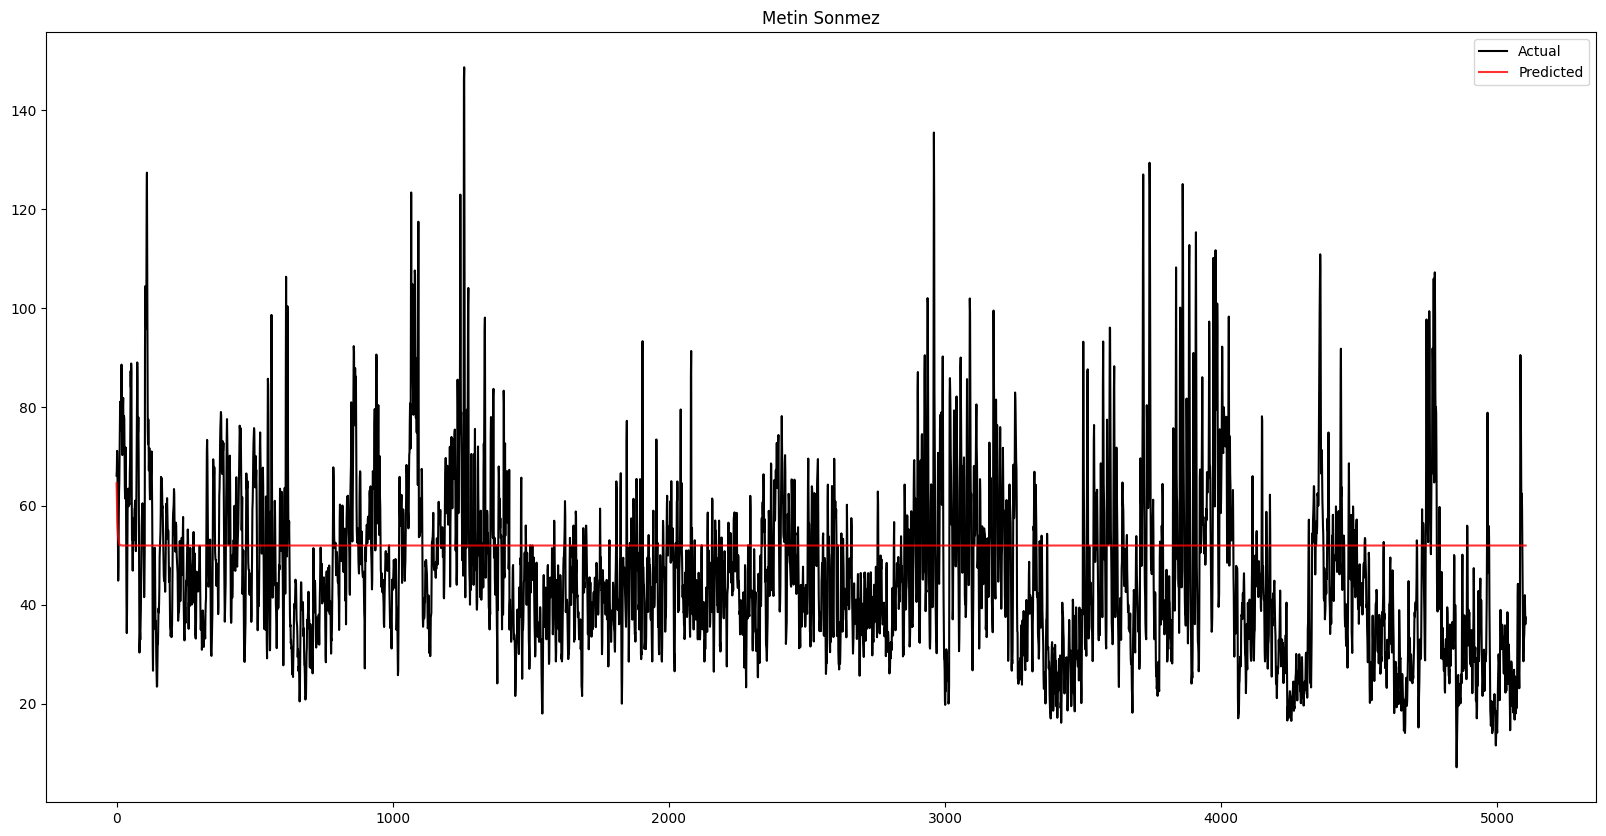

In [ ]:
plt.figure(figsize=(20,10))


plt.plot(filtered_testY, color='black', label='Actual')
plt.plot(filtered_testPredict, color='red', alpha=0.8 ,label='Predicted')
plt.legend()
plt.title("Metin Sonmez")

plt.show()

[(0, 0, 0), (0, 0, 1), (0, 0, 2), (0, 1, 0), (0, 1, 1), (0, 1, 2), (1, 0, 0), (1, 0, 1), (1, 0, 2), (1, 1, 0), (1, 1, 1), (1, 1, 2), (2, 0, 0), (2, 0, 1), (2, 0, 2), (2, 1, 0), (2, 1, 1), (2, 1, 2)]


In [ ]:
import pandas as pd

# Örnek bir DataFrame oluşturma
df = pd.DataFrame({'A': [1, 2, 3], 'B': [4, 5, 6]})

# Google Drive'a kaydetme
df.to_csv('/content/drive/My Drive/dosya_adi.csv', index=False)